## Kue Dataset - Model6
Model6 --> vgg16


In [123]:
# conda install -c conda-forge keras

In [124]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
# PATH_DATA = '../data/'
# PATH_DATA_IMAGES = '../../../../My_Dataset/images/dataset257/'
PATH_DATA_IMAGES = 'drive/MyDrive/Repository/Data/dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = 'drive/MyDrive/Repository/Model/'

In [127]:
os.listdir(PATH_DATA_TRAIN)

['.DS_Store',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_risoles',
 'kue_klepon',
 'kue_putri_salju',
 'kue_lumpur',
 'kue_lapis',
 'kue_serabi']

## Modeling

In [128]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model
from keras.applications import vgg16


In [129]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [130]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [131]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 224

In [132]:
# ?Conv2D

In [133]:
basic = vgg16.VGG16(weights='imagenet', include_top=False, 
                        input_shape=(224,224,3))

flatten = Flatten()
new_layer2 = Dense(LABEL_SIZE, activation='softmax', name='my_dense_cake')

inp2 = basic.input
out2 = flatten(basic.output)
out2 = new_layer2(out2)

just_cake_model = Model(inp2, out2)

In [134]:
just_cake_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [135]:
## compile model
opt = optimizers.Adam(learning_rate=0.00001)
just_cake_model.compile(
              loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',
                      #  metrics.SparseCategoricalAccuracy(),
                       metrics.AUC()])

In [136]:
## data generator
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.35,
        rotation_range=75,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.6,
        # horizontal_flip=True
        )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Shuffle = True
train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [137]:
## save best model and use early stopping
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=9) 
check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model-colab6.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=60)

Epoch 1/60
47/47 [==============================] - 59s 1s/step - loss: 2.0775 - accuracy: 0.2058 - auc_10: 0.5847 - val_loss: 1.6723 - val_accuracy: 0.4062 - val_auc_10: 0.7780
Epoch 2/60
47/47 [==============================] - 42s 895ms/step - loss: 1.5105 - accuracy: 0.4767 - auc_10: 0.8364 - val_loss: 1.0971 - val_accuracy: 0.5875 - val_auc_10: 0.9137
Epoch 3/60
47/47 [==============================] - 43s 904ms/step - loss: 1.0754 - accuracy: 0.6256 - auc_10: 0.9181 - val_loss: 0.9080 - val_accuracy: 0.6812 - val_auc_10: 0.9408
Epoch 4/60
47/47 [==============================] - 43s 908ms/step - loss: 0.8884 - accuracy: 0.6927 - auc_10: 0.9420 - val_loss: 0.6472 - val_accuracy: 0.7750 - val_auc_10: 0.9707
Epoch 5/60
47/47 [==============================] - 43s 901ms/step - loss: 0.7211 - accuracy: 0.7571 - auc_10: 0.9634 - val_loss: 0.5784 - val_accuracy: 0.8313 - val_auc_10: 0.9759
Epoch 6/60
47/47 [==============================] - 43s 900ms/step - loss: 0.6034 - accuracy: 0.79

## Evaluations

In [138]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

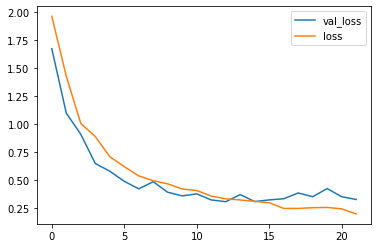

In [139]:
df_epoch_hist[['val_loss','loss']].plot()

In [140]:
# depd = {'auc_1' : metrics.AUC}
model_load6 = load_model(PATH_MODEL + 'just_cake_model-colab6.h5')

In [141]:
model_load6.evaluate(val_generator)

5/5 [==============================] - 2s 340ms/step - loss: 0.3060 - accuracy: 0.8813 - auc_10: 0.9906


[0.3059829771518707, 0.8812500238418579, 0.9905719757080078]

In [142]:
def eval_model(gen_,model_load):
  per = np.random.permutation(gen_.n)
  gen_.index_array = per
  y_true = gen_.classes[per]

  predictions = model_load.predict(gen_)
  y_pred = np.argmax(predictions, axis=1)

  cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
  plt.figure(figsize = (12,8))
  sns.heatmap(cm, annot= True)
  print(classification_report(y_true, y_pred))

#### 1. Train

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       192
           1       0.98      0.78      0.87       181
           2       0.99      0.93      0.96       197
           3       0.87      0.95      0.91       201
           4       0.93      0.89      0.91       197
           5       0.92      0.93      0.93       172
           6       0.82      0.87      0.84       196
           7       0.87      0.87      0.87       180

    accuracy                           0.89      1516
   macro avg       0.90      0.89      0.89      1516
weighted avg       0.90      0.89      0.89      1516



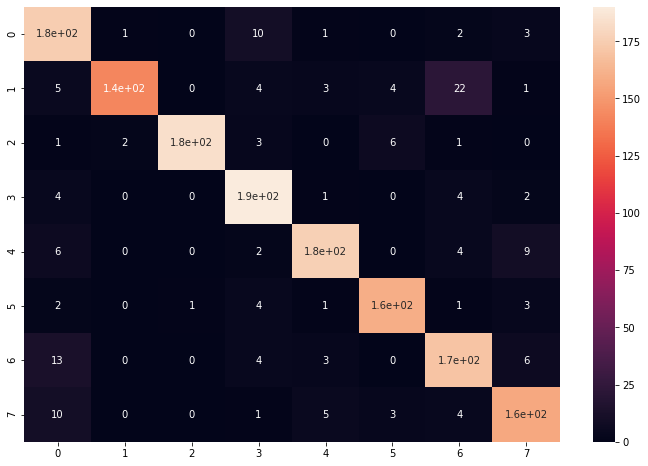

In [143]:
eval_model(train_generator, model_load6)

#### 2. Validations

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       1.00      0.80      0.89        20
           2       0.95      0.90      0.92        20
           3       0.90      0.90      0.90        20
           4       0.88      0.75      0.81        20
           5       0.90      0.95      0.93        20
           6       0.82      0.90      0.86        20
           7       0.79      0.95      0.86        20

    accuracy                           0.88       160
   macro avg       0.89      0.88      0.88       160
weighted avg       0.89      0.88      0.88       160



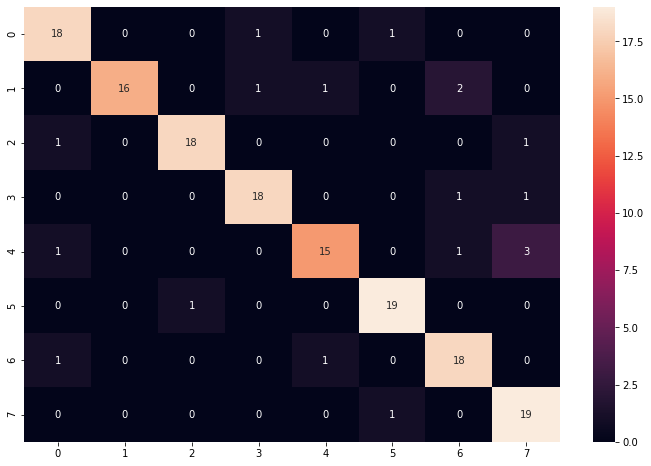

In [144]:
eval_model(val_generator, model_load6)

#### 3. Test

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       1.00      0.82      0.90        22
           2       1.00      0.95      0.97        20
           3       0.95      1.00      0.98        20
           4       0.90      0.90      0.90        20
           5       0.85      0.94      0.89        18
           6       0.83      1.00      0.91        20
           7       0.85      0.85      0.85        20

    accuracy                           0.92       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.93      0.92      0.92       160



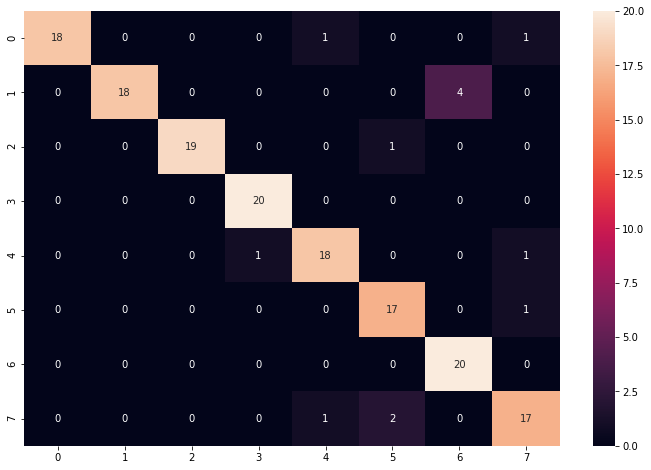

In [145]:
eval_model(test_generator, model_load6)